For displaying images

In [ ]:


def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        true_label = os.path.normpath(image_filepath).split(os.sep)[-2]
        predicted_label = predicted_labels[i] if predicted_labels else true_label
        color = "green" if true_label == predicted_label else "red"
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(predicted_label, color=color)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()




Data Pre-procssing & Augmentation

In [ ]:
from collections import defaultdict
import copy
import random
import os
import shutil
from urllib.request import urlretrieve
import numpy as np


import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models


import torch.optim.lr_scheduler as lr_scheduler


cudnn.benchmark = True

from PIL import Image

In [ ]:
#data_path = './Train'

root_directory = '/content/drive/MyDrive/Train'

buildings_directory = os.path.join(root_directory, "buildings")
forest_directory = os.path.join(root_directory, "forest")
glacier_directory = os.path.join(root_directory, "glacier")
mountain_directory = os.path.join(root_directory, "mountain")
sea_directory = os.path.join(root_directory, "sea")
street_directory = os.path.join(root_directory, "street")

building_images_path = sorted([os.path.join(buildings_directory, f) for f in os.listdir(buildings_directory)])
forest_images_path = sorted([os.path.join(forest_directory, f) for f in os.listdir(forest_directory)])
glacier_images_path = sorted([os.path.join(glacier_directory, f) for f in os.listdir(glacier_directory)])
mountain_images_path = sorted([os.path.join(mountain_directory, f) for f in os.listdir(mountain_directory)])
sea_images_path = sorted([os.path.join(sea_directory, f) for f in os.listdir(sea_directory)])
street_images_path = sorted([os.path.join(street_directory, f) for f in os.listdir(street_directory)])

images_filepaths = [*building_images_path, *forest_images_path, *glacier_images_path, *mountain_images_path, *sea_images_path, *street_images_path]

random.seed(42)
random.shuffle(images_filepaths)
train_images_fp = images_filepaths[:int(len(images_filepaths) * 0.8)]
#train_images_fp = images_filepaths[:64]
val_images_fp = images_filepaths[int(len(images_filepaths) * 0.8):]
#val_images_fp = images_filepaths[:64]
print(len(train_images_fp))
print(len(val_images_fp))

9536
2384


In [ ]:
class Classification(Dataset):
    def __init__(self, images_fp, transform = None):
        self.images_filepath = images_fp
        self.transform = transform

    def __len__(self):
        return len(self.images_filepath)
    
    def __getitem__(self, idx):
        images_filepath = self.images_filepath[idx]
        image = cv2.imread(images_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #image = Image.open(images_filepath)

        if os.path.normpath(images_filepath).split(os.sep)[-2] == "buildings":
            label = 0

        elif os.path.normpath(images_filepath).split(os.sep)[-2] == "forest":
            label = 1
        elif os.path.normpath(images_filepath).split(os.sep)[-2] == "glacier":
            label = 2
        elif os.path.normpath(images_filepath).split(os.sep)[-2] == "mountain":
            label = 3
        elif os.path.normpath(images_filepath).split(os.sep)[-2] == "sea":
            label = 4
        else: #street
            label = 5

        if self.transform is not None:
            #print("transform is True")
            image = self.transform(image=image)["image"]
        return image, label

In [ ]:
train_transform = A.Compose(
    [
        #A.SmallestMaxSize(max_size=150),
        #A.LongestMaxSize(max_size=150),
        A.Resize(150, 150),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=30, p=0.5),
        A.ChannelShuffle(p = 0.2),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        #A.RandomCrop(height=128, width=128),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

val_transform = A.Compose(
    [
        #A.SmallestMaxSize(max_size=150),
        #A.LongestMaxSize(max_size=150),
        A.Resize(150, 150),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)



In [ ]:
train_dataset = Classification(train_images_fp, transform=train_transform)
val_dataset = Classification(val_images_fp,transform=val_transform)

In [ ]:


def visualize_augmentations(dataset, idx=0, samples=4, cols=2):
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i in range(samples):
        image, _ = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()



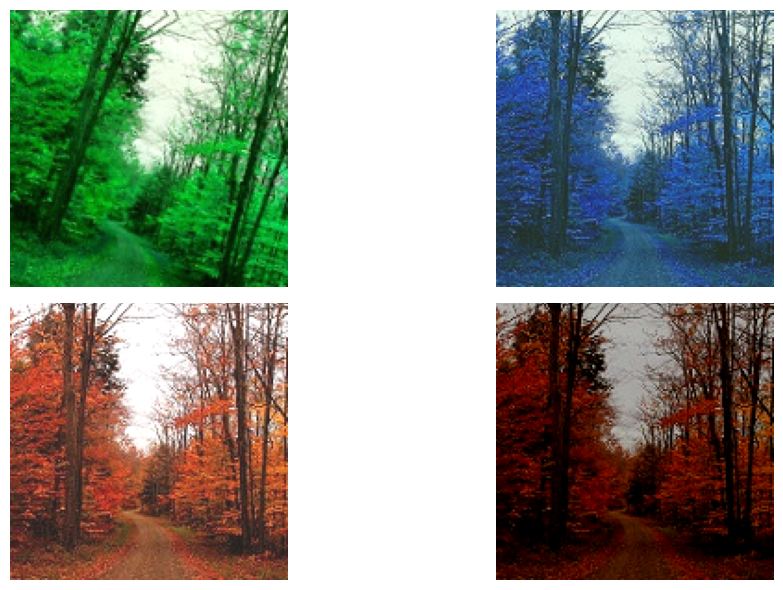

In [ ]:
random.seed(42)
visualize_augmentations(train_dataset)

Training

In [ ]:

def calculate_accuracy(output, target):
    predictions = torch.argmax(torch.softmax(output, dim = 1, dtype = None), dim = 1)
    predictions = predictions.cpu().numpy()
    target = target.cpu().numpy()

    return (np.sum(target == predictions)/len(predictions))

In [ ]:


class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"], float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )



In [ ]:
params = {
    "model": "resnet101",
    "device": "cuda",
    "lr": 0.0001,
    "batch_size": 128,
    "num_workers": 0,
    "epochs": 25,
}

In [ ]:
model = getattr(models, params["model"])(pretrained=False, num_classes=6,)
model = model.to(params["device"])
criterion = nn.CrossEntropyLoss().to(params["device"])
optimizer = torch.optim.Adam(model.parameters(), lr=params["lr"], weight_decay=1e-5)

 
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
##TODO: learning rate scheduler


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
train_loader = DataLoader(
    train_dataset, batch_size=params["batch_size"], shuffle=True, num_workers=params["num_workers"], pin_memory=True,
)
val_loader = DataLoader(
    val_dataset, batch_size=params["batch_size"], shuffle=False, num_workers=params["num_workers"], pin_memory=True,
)



In [ ]:
# storing accuracy

train_accs = []
val_accs = []

In [ ]:


def validate(val_loader, model, criterion, epoch, params):
    metric_monitor = MetricMonitor()
    model.eval()
    stream = tqdm(val_loader)
    temp_accs = []
    with torch.no_grad():
        for i, (images, target) in enumerate(stream, start=1):
            images = images.to(params["device"], non_blocking=True).float()
            #target = target.to(params["device"], non_blocking=True).float().view(-1, 1)
            target = target.to(params["device"], non_blocking=True)
            output = model(images)
            loss = criterion(output, target)
            accuracy = calculate_accuracy(output, target)
            temp_accs.append(accuracy)
            metric_monitor.update("Loss", loss.item())
            metric_monitor.update("Accuracy", accuracy)
            stream.set_description(
                "Epoch: {epoch}. Validation. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
            )
    val_accs.append(np.mean(temp_accs))



In [ ]:


def train(train_loader, model, criterion, optimizer, epoch, params):
    metric_monitor = MetricMonitor()
    model.train()
    stream = tqdm(train_loader)
    temp_accs = []
    for i, (images, target) in enumerate(stream, start=1):
        images = images.to(params["device"], non_blocking=True).float()
        #target = target.to(params["device"], non_blocking=True).float().view(-1, 1)
        target = target.to(params["device"], non_blocking=True)
        #print(images.shape)
        output = model(images)
        #print(images)
        loss = criterion(output, target)
        accuracy = calculate_accuracy(output, target)
        temp_accs.append(accuracy)
        metric_monitor.update("Loss", loss.item())
        metric_monitor.update("Accuracy", accuracy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        stream.set_description(
            "Epoch: {epoch}. Train.      {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
        )
    train_accs.append(np.mean(temp_accs))



Save Model

In [ ]:
for epoch in range(1, params["epochs"] + 1):
    train(train_loader, model, criterion, optimizer, epoch, params)

    if epoch % 5 == 0:
      torch.save({
                  'epoch': epoch,
                  'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'loss': 0.6,
                  }, "/content/drive/MyDrive/vip_sp23_weights/resnet101_{}.pt".format(epoch))
    

    validate(val_loader, model, criterion, epoch, params)

Epoch: 1. Train.      Loss: 1.592 | Accuracy: 0.342: 100%|██████████| 75/75 [37:32<00:00, 30.04s/it]
Epoch: 1. Validation. Loss: 1.280 | Accuracy: 0.485: 100%|██████████| 19/19 [09:08<00:00, 28.88s/it]
Epoch: 2. Train.      Loss: 1.236 | Accuracy: 0.513: 100%|██████████| 75/75 [01:17<00:00,  1.04s/it]
Epoch: 2. Validation. Loss: 1.273 | Accuracy: 0.528: 100%|██████████| 19/19 [00:13<00:00,  1.44it/s]
Epoch: 3. Train.      Loss: 1.107 | Accuracy: 0.562: 100%|██████████| 75/75 [01:17<00:00,  1.04s/it]
Epoch: 3. Validation. Loss: 0.990 | Accuracy: 0.624: 100%|██████████| 19/19 [00:13<00:00,  1.41it/s]
Epoch: 4. Train.      Loss: 1.036 | Accuracy: 0.598: 100%|██████████| 75/75 [01:17<00:00,  1.04s/it]
Epoch: 4. Validation. Loss: 0.955 | Accuracy: 0.633: 100%|██████████| 19/19 [00:13<00:00,  1.42it/s]
Epoch: 5. Train.      Loss: 0.994 | Accuracy: 0.619: 100%|██████████| 75/75 [01:17<00:00,  1.04s/it]
Epoch: 5. Validation. Loss: 0.994 | Accuracy: 0.632: 100%|██████████| 19/19 [00:14<00:00,  

Testing

In [ ]:
root_directory = '/content/drive/MyDrive/Test'

buildings_directory = os.path.join(root_directory, "buildings")
forest_directory = os.path.join(root_directory, "forest")
glacier_directory = os.path.join(root_directory, "glacier")
mountain_directory = os.path.join(root_directory, "mountain")
sea_directory = os.path.join(root_directory, "sea")
street_directory = os.path.join(root_directory, "street")

building_images_path = sorted([os.path.join(buildings_directory, f) for f in os.listdir(buildings_directory)])
forest_images_path = sorted([os.path.join(forest_directory, f) for f in os.listdir(forest_directory)])
glacier_images_path = sorted([os.path.join(glacier_directory, f) for f in os.listdir(glacier_directory)])
mountain_images_path = sorted([os.path.join(mountain_directory, f) for f in os.listdir(mountain_directory)])
sea_images_path = sorted([os.path.join(sea_directory, f) for f in os.listdir(sea_directory)])
street_images_path = sorted([os.path.join(street_directory, f) for f in os.listdir(street_directory)])

test_images_filepaths = [*building_images_path, *forest_images_path, *glacier_images_path, *mountain_images_path, *sea_images_path, *street_images_path]


random.seed(42)
random.shuffle(test_images_filepaths)

#test_images_filepaths = test_images_filepaths[:128]


In [ ]:


class InferenceDataset(Dataset):
    def __init__(self, images_filepath, transform=None):
        self.images_filepath = images_filepath
        self.transform = transform

    def __len__(self):
        return len(self.images_filepath)

    def __getitem__(self, idx):
        images_filepath = self.images_filepath[idx]
        image = cv2.imread(images_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #image = Image.open(images_filepath)

        if os.path.normpath(images_filepath).split(os.sep)[-2] == "buildings":
            label = 0

        elif os.path.normpath(images_filepath).split(os.sep)[-2] == "forest":
            label = 1
        elif os.path.normpath(images_filepath).split(os.sep)[-2] == "glacier":
            label = 2
        elif os.path.normpath(images_filepath).split(os.sep)[-2] == "mountain":
            label = 3
        elif os.path.normpath(images_filepath).split(os.sep)[-2] == "sea":
            label = 4
        else: #street
            label = 5

        if self.transform is not None:
            #print("transform is True")
            image = self.transform(image=image)["image"]
        return image, label


test_transform = A.Compose(
    [
        A.SmallestMaxSize(max_size=150),
        A.CenterCrop(height=128, width=128),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

test_dataset = InferenceDataset(images_filepath=test_images_filepaths, transform=test_transform)
test_loader = DataLoader(
    test_dataset, batch_size=params["batch_size"], shuffle=False, num_workers=params["num_workers"], pin_memory=True,
)



In [ ]:
# reload model if necessary
checkpoint = torch.load('/content/drive/MyDrive/vip_sp23_weights/resnet152_25.pt')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

In [ ]:


def test(test_loader, model, criterion, params):
    metric_monitor = MetricMonitor()
    model.eval()
    stream = tqdm(test_loader)
    with torch.no_grad():
        for i, (images, target) in enumerate(stream, start=1):
            images = images.to(params["device"], non_blocking=True).float()
            #target = target.to(params["device"], non_blocking=True).float().view(-1, 1)
            target = target.to(params["device"], non_blocking=True)
            output = model(images)
            loss = criterion(output, target)
            accuracy = calculate_accuracy(output, target)

            metric_monitor.update("Loss", loss.item())
            metric_monitor.update("Accuracy", accuracy)
            stream.set_description(
                " Test. {metric_monitor}".format(metric_monitor=metric_monitor)
            )


In [ ]:
test(test_loader, model, criterion, params)

In [ ]:
print(val_accs)

In [ ]:
plt.plot(val_accs)
plt.show()


In [ ]:


model = model.eval()
predicted_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(params["device"], non_blocking=True)
        output = model(images)
        predictions = torch.argmax(torch.softmax(output, dim = 1, dtype = None), dim = 1)
        predictions = predictions.cpu().numpy()

        for p in predictions:

          if p == 0:
            predicted_labels += ["buildings"]
          elif p == 1:
            predicted_labels += ["forest"]
          elif p == 2:
            predicted_labels += ["glacier"]
          elif p == 3:
            predicted_labels += ["mountain"]
          elif p == 4:
            predicted_labels += ["sea"]
          else: #street
            predicted_labels += ["street"]



In [ ]:
display_image_grid(test_images_filepaths[30:50], predicted_labels[30:50])


Metrics


In [ ]:
!pip install torchmetrics

In [ ]:
# multi labelprecision


import torchmetrics

target = []
for i, image_filepath in enumerate(test_images_filepaths):
    label = os.path.normpath(image_filepath).split(os.sep)[-2]

    if label == "buildings":
          target.append(0)
    elif label == "forest":
          target.append(1)

    elif label == "glacier":
          target.append(2)

    elif label == "mountain":
          target.append(3)

    elif label == "sea":
          target.append(4)

    else:
          target.append(5)


model = model.eval()
preds = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(params["device"], non_blocking=True)
        output = model(images)
        predictions = torch.softmax(output, dim = 1, dtype = None)

        predictions = predictions.cpu().numpy()

        preds.extend(predictions)



In [ ]:
pr_curve = torchmetrics.PrecisionRecallCurve(task="multiclass", num_classes = 6)
pr_curve_precision, pr_curve_recall, pr_curve_thresholds = pr_curve(torch.from_numpy(np.asarray(preds)), torch.from_numpy(np.asarray(target)))

In [ ]:
precision = torchmetrics.Precision(task="multiclass", average='macro', num_classes=6)
p = precision(torch.from_numpy(np.asarray(preds)), torch.from_numpy(np.asarray(target)))

recall = torchmetrics.Recall(task="multiclass", average='macro', num_classes=6)
r = recall(torch.from_numpy(np.asarray(preds)), torch.from_numpy(np.asarray(target)))

In [ ]:
roc = torchmetrics.ROC(task="multiclass", num_classes = 6)
fpr, tpr, thresholds = roc(torch.from_numpy(np.asarray(preds)), torch.from_numpy(np.asarray(target)))

In [ ]:
confmat = torchmetrics.ConfusionMatrix(task="multiclass", num_classes=6)
conf_mat = confmat(torch.from_numpy(np.asarray(preds)), torch.from_numpy(np.asarray(target)))

In [ ]:
average_precision = torchmetrics.AveragePrecision(task="multiclass", num_classes=6, average=None)
avg_precision = average_precision(torch.from_numpy(np.asarray(preds)), torch.from_numpy(np.asarray(target)))

Plots

In [ ]:
# pr curve

plt.plot(pr_curve_precision[0], pr_curve_recall[0], label = "Building")
plt.plot(pr_curve_precision[1], pr_curve_recall[1], label = "Forest")
plt.plot(pr_curve_precision[2], pr_curve_recall[2], label = "Glacier")
plt.plot(pr_curve_precision[3], pr_curve_recall[3], label = "Mountain")
plt.plot(pr_curve_precision[4], pr_curve_recall[4], label = "Sea")
plt.plot(pr_curve_precision[5], pr_curve_recall[5], label = "Street")
plt.legend()
plt.show()

In [ ]:
# ROC Curve

plt.plot(fpr[0], tpr[0], label = "Building")
plt.plot(fpr[1], tpr[1], label = "Forest")
plt.plot(fpr[2], tpr[2], label = "Glacier")
plt.plot(fpr[3], tpr[3], label = "Mountain")
plt.plot(fpr[4], tpr[4], label = "Sea")
plt.plot(fpr[5], tpr[5], label = "Street")
plt.plot(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01), label = "Random")
plt.legend()
plt.show()

In [ ]:
conf_mat